![datiaperti logo](images/datiaperti_small.png)

# The Copernicus Climate Change Service
The Copernicus Climate Change Service ([C3S](https://climate.copernicus.eu/)) provides information about climate change through  historical data sets (reanalysis) and projections of essential climate variables such as winds, precipitation, temperature, pressure, greenhouse gases. C3S is operated by the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int/)) on behalf of the European Commission.

The purpose of this notebook is

1. Test the C3S web service API
2. Plot the 2m air temperatures on a map over Italy at a given time slice
3. As an exercise, we compute the mean temperatures in Rome in September 2020 and then we plot the result as time series.  

## The ERA5 reanalysis dataset
ERA5 reanalysis is a dataset that combines a vast amount of observations of the climate variables from the near real time back to, so far, 1979. The aim of the project is to assimilate historical observations back to 1950. The dataset is provided as a Level 3 product so that the observations are already interpolated at the grid points. ERA5 contains estimations of many climate variables on a grid whose horizontal resolution, the distance between any two points on the grid, is 0.5°x0.5° or 55 km for atmospheric data. The ERA5 estimations are computed by integrating the values obtained using the ECMWF climate model with the historical observations from in-situ and satellite data. 

### Data assimilation
The technique used to integrate the model data with the observations is called assimilation. An estimation of the state of the climate variables is computed for every hour by ECMWF earth system. The model estimations are compared with the observations at any grid point. Since both observations and model data have errors a cost function is used to compute the distance between the two values, weighted by their errors. The result, obtained by minimizing the cost function, represents a better estimation of the climate variables at any time slice and grid point. The set of estimations, corrected using the observations, represents an analysis that is used as new input for the next iteration of the model whose result will be again compared with the observations available at that time slice to produce the corresponding analysis. More information about the technique can be found in the [references](#References)          

## The ERA5 hourly 2m-temperature
We select the [C3S ERA5 hourly data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels) data set to retrieve the temperature data over the Italian region between September and October 2020. The 2m temperature is the temperature of the air at 2m above the surface, land and sea. Since we want to limit the size of the data we choose a frequency of 3 hours. The format of the data is [NetCDF4](https://www.unidata.ucar.edu/software/netcdf/docs/netcdf_introduction.html). According to our selection the data will contain a cube of 8 time slices per day of temperature values, for each grid point in the selected area. The selected area is between 47.12 degrees latitude North, 36.4 latitude South and 6.57 degrees longitude West and 18.52 longitude East. The selected area contains 43x48 = 2064 points so each table, or slice, contains 2064 temperature values (in Kelvin).

## The ERA5 hourly data web service
In order to use the API, you have to be registered into the CDS and

1. login 
2. copy your CDS API key in the .condarc file in your home folder 
3. install the cdsapi Python package

For more information follow the [how-to instructions](https://cds.climate.copernicus.eu/api-how-to). Pay attention to not confuse the CDS API key with the ADS API key that is used to access the Atmosphere Monitoring Service.

We import all the Python packages that will be used to retrieve the data. We will import additional packages later on for plotting the temperatures.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)

python version: 3.8.2
pandas version: 1.0.2
xarray version: 0.14.0


In [17]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature'
        ],
        'year': '2020',
        'month': [
            '09', '10',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': [
            47.12, 6.57, 36.4,
            18.52,
        ],
        'format': 'netcdf',
    },
    './data/2m_temperature.nc')

2020-10-20 21:40:44,751 INFO Welcome to the CDS
2020-10-20 21:40:44,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-10-20 21:40:45,146 INFO Request is completed
2020-10-20 21:40:45,149 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1603222804.9651692-22858-15-87ceaef6-680b-4301-a988-f77ce9168d12.nc to ./data/2m_temperature.nc (1.5M)
2020-10-20 21:40:46,048 INFO Download rate 1.6M/s   


Result(content_length=1522004,content_type=application/x-netcdf,location=http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1603222804.9651692-22858-15-87ceaef6-680b-4301-a988-f77ce9168d12.nc)

We read the data and visualize some information about the content.

In [2]:
era5_ds = xr.open_dataset('data/2m_temperature.nc')
era5_ds

<xarray.Dataset>
Dimensions:    (latitude: 43, longitude: 48, time: 368)
Coordinates:
  * longitude  (longitude) float32 6.57 6.82 7.07 7.32 ... 17.82 18.07 18.32
  * latitude   (latitude) float32 46.9 46.65 46.4 46.15 ... 36.9 36.65 36.4
  * time       (time) datetime64[ns] 2020-09-01 ... 2020-10-16T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-20 19:40:27 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

As we can see from the dimensions, the data contains 43x48 = 2064 grid points for each time slice between September 1st 2020 and few days before the date in which dataset has been acquired (near real time) available as the last entry of the time dimension. .

In [3]:
lats = era5_ds['latitude']
print("Latitude West: {0:.2f}, Latitude East: {1:.2f}".format(lats.data.min(), lats.data.max()))

Latitude West: 36.40, Latitude East: 46.90


In [4]:
lons = era5_ds['longitude']
print("Longitude South: {0:.2f}, Longitude North: {1:.2f}".format(lons.data.min(), lons.data.max()))

Longitude South: 6.57, Longitude North: 18.32


Now we extract the temperature data from the data set and then we close the file since we won't need it anymore. 

In [5]:
temperature2m = era5_ds['t2m']
era5_ds.close()

## Multidimensional arrays
The temperatures are stored in a three dimensional array as shown in the picture, so that each temperature value is addressed by three coordinates or indexes. The first index represents the time slices, the 2nd and 3rd indexes represent the latitude and the longitude respectively. Instead of using integer indexes, as in a normal array, we can use a time index, and latitude and longitude as space indexes. The values for time, latitude and longitude must be the exact values that are in the data array. The use of index values that are different from those available in the data array will result in a key error. We need to know only the first value of each index and the distance between two consecutive values. For the time index the distance is 3 hours and for latitute and longitude is 0.25 degrees.

![GitHub Logo](images/xarray-dataset-diagram.png)

Here we choose two different time slices at the same grid point to compute the mean temporal temperature

In [6]:
temp1 = temperature2m.sel(time='2020-09-01T00:00:00', latitude = 46.90, longitude = 6.57).values.item()
temp2 = temperature2m.sel(time='2020-09-01T03:00:00', latitude = 46.90, longitude = 6.57).values.item()
temporal_mean = (temp2 + temp1) / 2
temporal_mean

283.59417724609375

Here we compute the mean temperature in two different adjacent grid points at the same time

In [7]:
tempA = temperature2m.sel(time='2020-09-01T00:00:00', latitude = 46.90, longitude = 6.57).values.item()
tempB = temperature2m.sel(time='2020-09-01T00:00:00', latitude = 46.65, longitude = 6.82).values.item()
spatial_mean = (tempA + tempB) / 2
spatial_mean

284.9122619628906

## Plotting the temperature data
We want to plot on a map one time slice of the temperature values, so we import the Python libraries.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

matplotlib version: 3.3.1
cartopy version: 0.18.0


We plot the data on a map using the [plate carre projection](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#platecarree), a particular case of the [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). We plot the costline and also rivers and lakes just to show that they are available. We plot only the first time slice, of Septmeber 1st 2020 at midnight.

Text(0.5, 1.0, 'ERA5 2 meter air temperature - 2020-09-01T00:00:00')

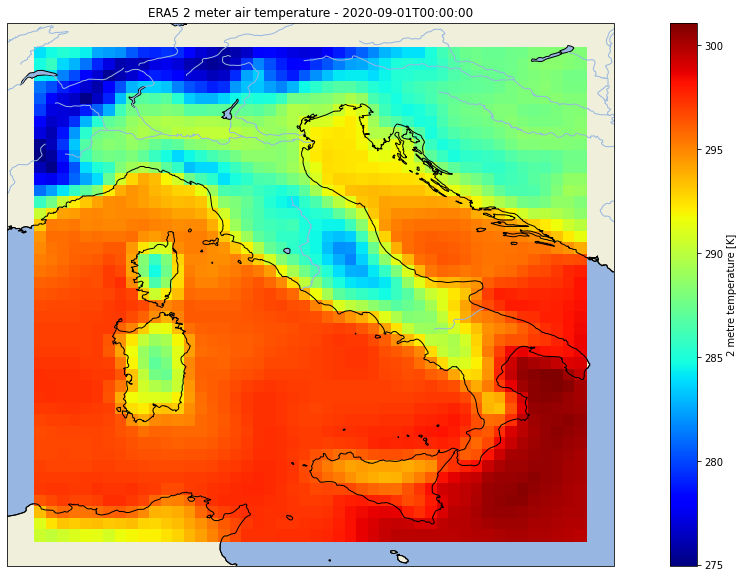

In [9]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.coastlines()
temperature2m.sel(time='2020-09-01T00:00:00').plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet')
plt.title('ERA5 2 meter air temperature - 2020-09-01T00:00:00')

The color of each cell, centered on one of the grid points, represents the temperature value.

We plot the data using the orthographic projection on the entire globe as well, even if our data cover only the Italian region. In order to plot the data into a different projection we need to transform the coordinates of the grid points. The transformation is performed by the cartopy library.

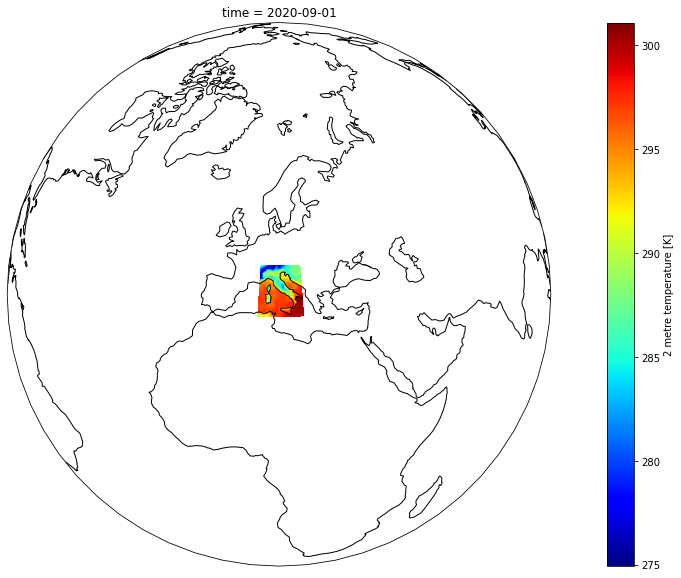

In [10]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=12, central_latitude=41))
ax.coastlines()
ax.set_global()
temperature2m.sel(time='2020-09-01T00:00:00').plot.pcolormesh(ax=ax, 
                                   x='longitude', 
                                   y='latitude', 
                                   add_colorbar=True, 
                                   cmap='jet', 
                                   transform=ccrs.PlateCarree())

## Computing the mean temperatures in Rome in September 2020
We want to compute the time series of the 2 meter temperatures in Rome for the month of September. We select the time slices from September 1st to September 30th, 8 time slices per day, and for each slice we select the grid points that lay within a bounding box between latitude Nord = 42.02 degrees and latitude South = 41.79 degrees, and between longitude West = 12.23 degrees and longitude East = 12.70 degrees. Then we compute the mean temperature for each time slice and finally we plot the time series of the 2m temperatures. 

In [11]:
latN = 42.02
latS = 41.79
lonW = 12.23
lonE = 12.70
rome_temp = temperature2m.sel(
                            time = slice('2020-09-01T00:00:00', '2020-09-30T21:00:00'),
                            latitude = slice(latN, latS), 
                            longitude = slice(lonW, lonE))
rome_temp.shape

(240, 1, 2)

As we can seen, our selection contains 30x8 = 240 time slices and only 1x2 = 2 grid point for each slice. We group the temperatures for Rome by time and we apply the meanCelsius() function to compute the average temperature of the grid points in each time slice. The temperatures are transformed from Kelvin to degree Celsius. 

In [14]:
def meanCelsius(t):
    # Computes the mean temperature in Celsius
    return t.mean() - 273.15

rome_mean_temp = rome_temp.groupby('time').apply(meanCelsius)
rome_mean_temp.shape

(240,)

Finally we plot the time series of the 2m temperatures for the city of Rome in September 2020.

Text(0.5, 0.98, 'Mean 2 meter temperature - Rome, September 2020 (°C)')

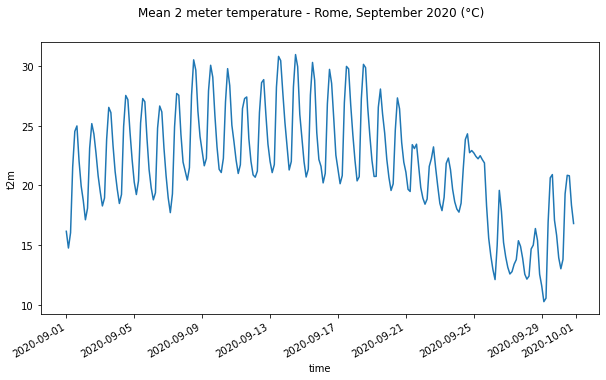

In [13]:
fig = plt.figure(figsize=(10, 5))
rome_mean_temp.plot.line()
plt.suptitle("Mean 2 meter temperature - Rome, September 2020 (°C)")

## References
- [Hersbach et al. - The ERA5 global reanalysis](https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/qj.3803)
- [Talagrand - Assimilation of Information, an Introduction](https://indico.fysik.su.se/event/2654/attachments/1559/1707/Talagrand.1987.pdf)
- [Law et al. - Data Assimilation: A Mathematical Introduction](https://arxiv.org/abs/1506.07825)
- [Carrassi et al. - Data Assimilation in the Geosciences](https://arxiv.org/abs/1709.02798)
- [Wikle et al. - A Bayesian tutorial for data assimilation](https://doi.org/10.1016/j.physd.2006.09.017) 
- [Geohackweek - Multidimensional Arrays](https://geohackweek.github.io/nDarrays/)
- [GEOGO133 - Terrestrial Carbon: Modelling and Monitoring 9) Data Assimilation](https://geog0113.readthedocs.io/en/latest/da.html)